## #01. 패키지 준비하기

In [1]:
import sys
sys.path.append('../../')
import helper

from pandas import read_excel, DataFrame, merge
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import StandardScaler

In [2]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 10
plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.unicode_minus"] = False

## #02. 데이터셋 준비하기

In [3]:
origin = read_excel("C:/Users/User/Desktop/서울시 주행실적 통계현황_1차수정.xlsx")
origin

,대상년도,관리 자치구,주행 실적 수,주행 거리,온실가스,마일리지
0,2021,광진구,1,1473,349,30000
1,2021,동대문구,1,6732,1595,70000
2,2021,강동구,1,1299,308,30000
3,2021,송파구,1,3896,923,70000
4,2021,송파구,1,1954,463,50000
...,...,...,...,...,...,...
14407,2018,종로구,23,125752,29591,1452900
14408,2018,종로구,20,154697,35981,1190000
14409,2018,종로구,14,68258,16196,820000
14410,2018,종로구,3,10973,2539,210000


## #03. 데이터 전처리

### 결측치 확인

In [4]:
origin.isna().sum()

대상년도       0
관리 자치구     0
주행 실적 수    0
주행 거리      0
온실가스       0
마일리지       0
dtype: int64

## #04. 탐색적 데이터 분석

### 기본통계 확인

In [5]:
origin.describe()

,대상년도,주행 실적 수,주행 거리,온실가스,마일리지
count,14412.000000,14412.000000,1.441200e+04,14412.000000,1.441200e+04
mean,2020.086664,8.743547,3.920099e+04,8942.829309,5.256993e+05
std,0.985382,18.409075,8.145699e+04,18732.785031,1.114703e+06
min,2018.000000,1.000000,0.000000e+00,0.000000,1.000000e+04
25%,2019.000000,1.000000,5.581750e+03,1251.750000,7.000000e+04
50%,2020.000000,3.000000,1.360100e+04,3069.000000,1.700000e+05
75%,2021.000000,8.000000,3.708700e+04,8426.250000,4.744700e+05
max,2021.000000,604.000000,2.711147e+06,626079.000000,3.733965e+07


> 평균값의 차이가 크기 때문에 표준화가 필요해 보인다.

### 상자그림

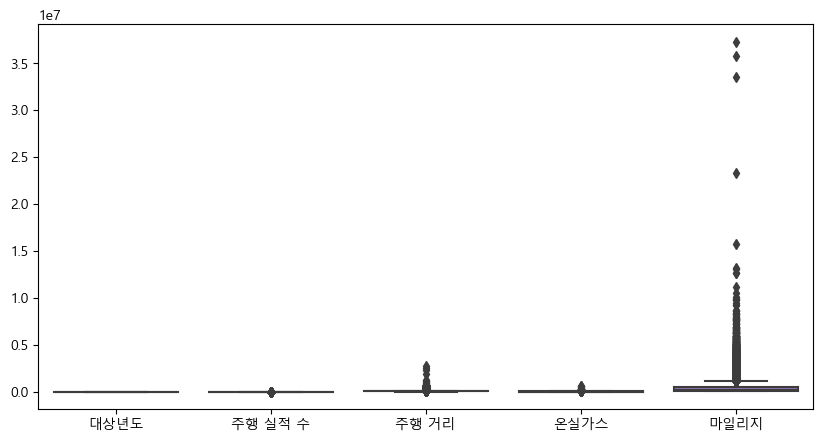

In [6]:
plt.figure(figsize=(10, 5))
sb.boxplot(data=origin)
plt.show()
plt.close()

> 데이터의 분포가 상이하므로 표준화가 필요해 보인다.

### 산점도 그래프와 추세선 확인

c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 3000x3000 with 0 Axes>

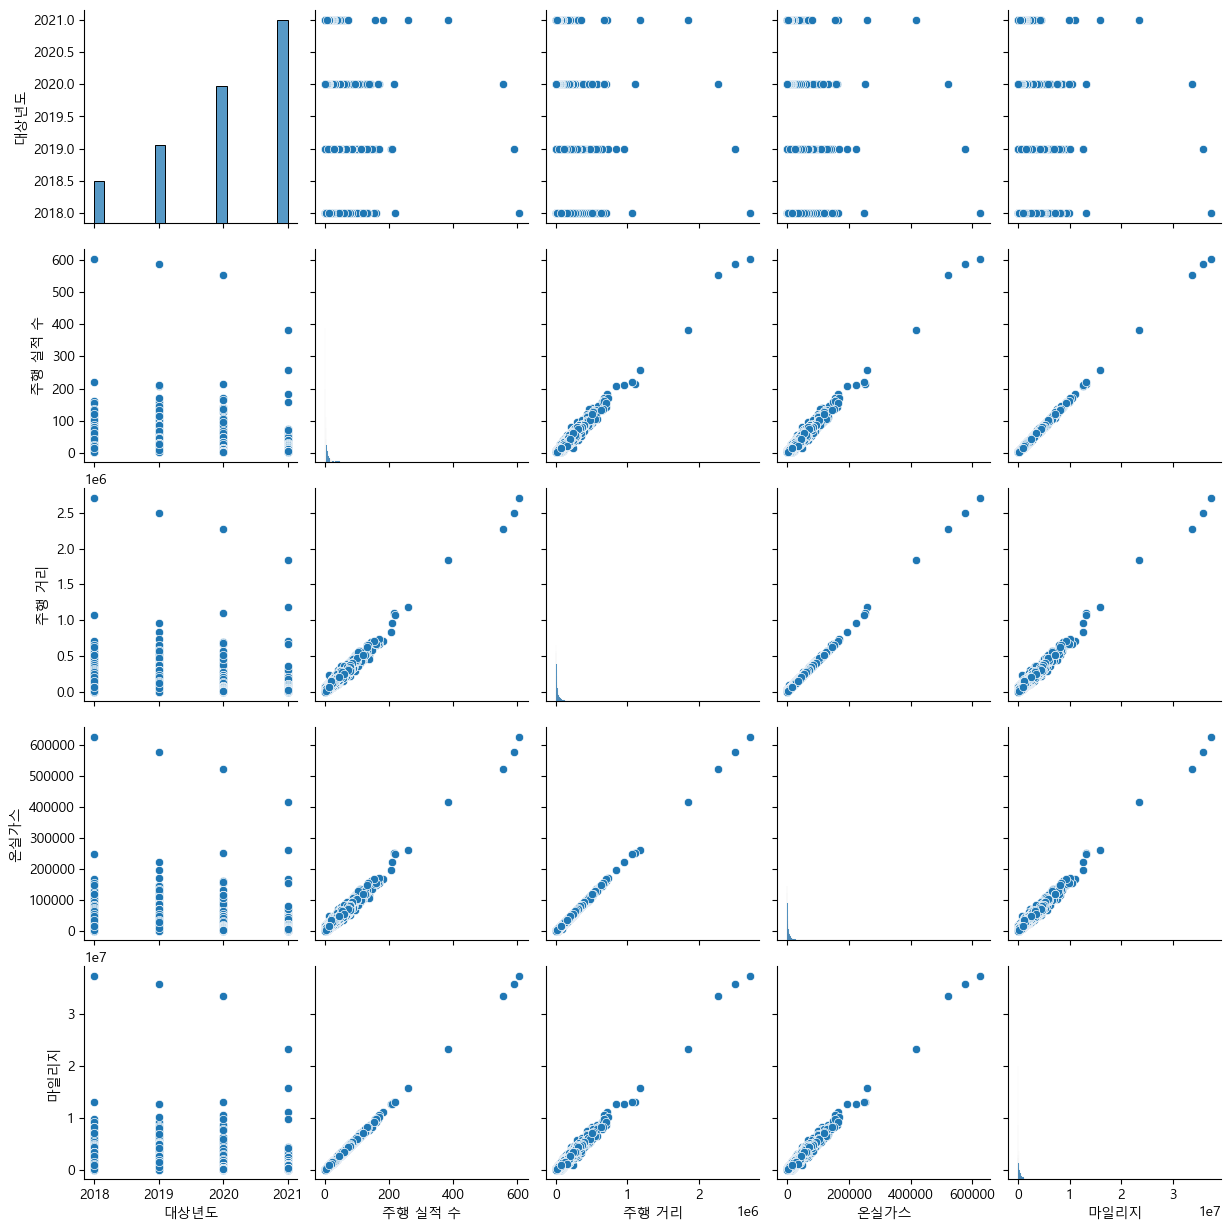

In [7]:
plt.figure(figsize=(30, 30))
sb.pairplot(origin)
plt.show()
plt.close()

## #05. 데이터셋 분할하기

### 랜덤시드 고정

In [8]:
np.random.seed(777)

In [9]:
origin.columns

Index(['대상년도', '관리 자치구', '주행 실적 수', '주행 거리', '온실가스', '마일리지'], dtype='object')

### 훈련 데이터(독립변수)와 레이블(종속변수) 구분하기

In [10]:
x = origin[['주행 실적 수', '주행 거리', '온실가스']]
y = origin[['마일리지']]
x.shape, y.shape

((14412, 3), (14412, 1))

### 데이터 표준화

In [11]:
x_scaller = StandardScaler()
x_scale = x_scaller.fit_transform(x)

y_scaller = StandardScaler()
y_scale = y_scaller.fit_transform(y)

x_scale.shape, y_scale.shape

((14412, 3), (14412, 1))

### 표준화 전 후 상자그림 비교

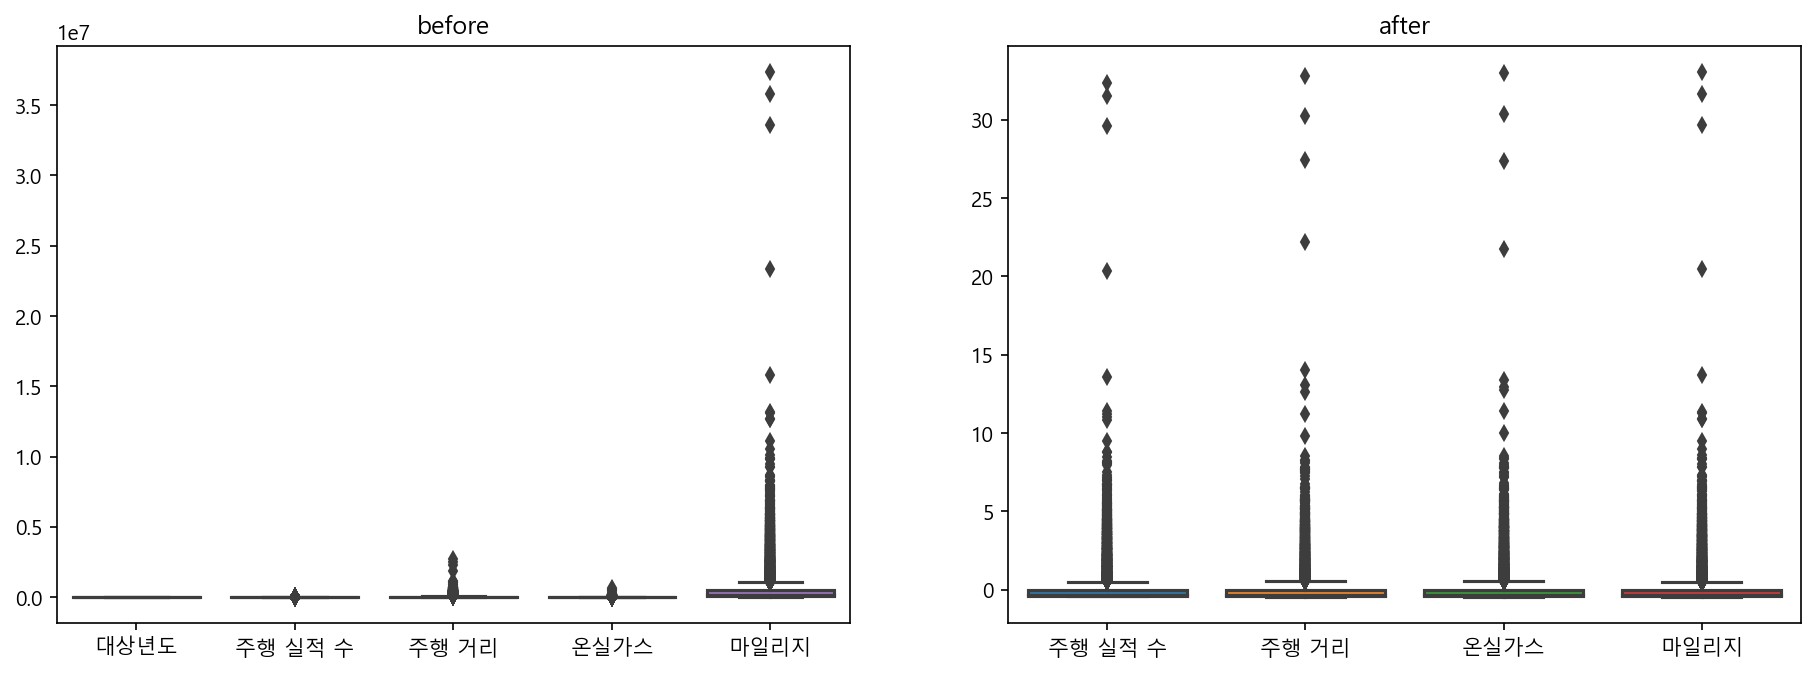

In [12]:
# 임시로 독립변수와 종속변수를 하나의 DataFrame으로 병합
x_scale_df = DataFrame(x_scale, columns=['주행 실적 수', '주행 거리', '온실가스'])
y_scale_df = DataFrame(y_scale, columns=['마일리지'])
tmp = merge(x_scale_df, y_scale_df, left_index=True, right_index=True)

fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
sb.boxplot(data=origin, ax=ax[0])
sb.boxplot(data=tmp, ax=ax[1])
ax[0].set_title('before')
ax[1].set_title('after')
plt.show()
plt.close()

### 훈련 데이터와 검증 데이터로 분할

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_scale, y_scale, test_size=0.3, random_state=777)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((10088, 3), (4324, 3), (10088, 1), (4324, 1))

## #06. 모델 개발

### 모델 정의

데이터가 단순하고 개수가 적다면 과대적합이 발생할 확률이 높기 때문에 주의하면서 적절한 크기의 모델층을 쌓아야 한다.

In [14]:
model = Sequential()

# 1차원의 데이터를 입력으로 받고, 64개의 출력을 가지는 첫 번째 Dense 층
model.add(Dense(64, activation = 'relu', input_shape = (len(x_train[0]), )))
model.add(Dense(32, activation = 'relu'))

# 하나의 값을 출력 정답의 범위가 정해지지 않기 때문에 활성화 함수는 linear
model.add(Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2369 (9.25 KB)
Trainable params: 2369 (9.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### 학습하기

In [15]:
result = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test), callbacks=[
    EarlyStopping(monitor='val_loss', patience=10, verbose=1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.001, verbose=1)
])

Epoch 1/500
316/316 [==============================] - 1s 2ms/step - loss: 0.0147 - mae: 0.0504 - val_loss: 0.0026 - val_mae: 0.0274 - lr: 0.0010
Epoch 2/500
316/316 [==============================] - 0s 1ms/step - loss: 0.0029 - mae: 0.0287 - val_loss: 0.0032 - val_mae: 0.0366 - lr: 0.0010
Epoch 3/500
316/316 [==============================] - 0s 1ms/step - loss: 0.0106 - mae: 0.0417 - val_loss: 0.0021 - val_mae: 0.0278 - lr: 0.0010
Epoch 4/500
316/316 [==============================] - 0s 1ms/step - loss: 0.0022 - mae: 0.0276 - val_loss: 0.0016 - val_mae: 0.0248 - lr: 0.0010
Epoch 5/500
316/316 [==============================] - 0s 1ms/step - loss: 0.0044 - mae: 0.0299 - val_loss: 0.0015 - val_mae: 0.0242 - lr: 0.0010
Epoch 6/500
316/316 [==============================] - 0s 1ms/step - loss: 0.0052 - mae: 0.0308 - val_loss: 0.0021 - val_mae: 0.0259 - lr: 0.0010
Epoch 7/500
316/316 [==============================] - 0s 1ms/step - loss: 0.0036 - mae: 0.0282 - val_loss: 0.0015 - val_mae

## #07. 학습 결과 평가

In [16]:
# 학습결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

,loss,mae,val_loss,val_mae,lr
epochs,,,,,
1,0.014720,0.050379,0.002551,0.027448,0.001
2,0.002858,0.028661,0.003199,0.036610,0.001
3,0.010599,0.041694,0.002126,0.027824,0.001
4,0.002248,0.027568,0.001551,0.024761,0.001
5,0.004437,0.029941,0.001509,0.024196,0.001
6,0.005163,0.030792,0.002080,0.025857,0.001
7,0.003560,0.028242,0.001512,0.023684,0.001
8,0.002826,0.028196,0.001640,0.024590,0.001
9,0.002130,0.026119,0.001559,0.024834,0.001


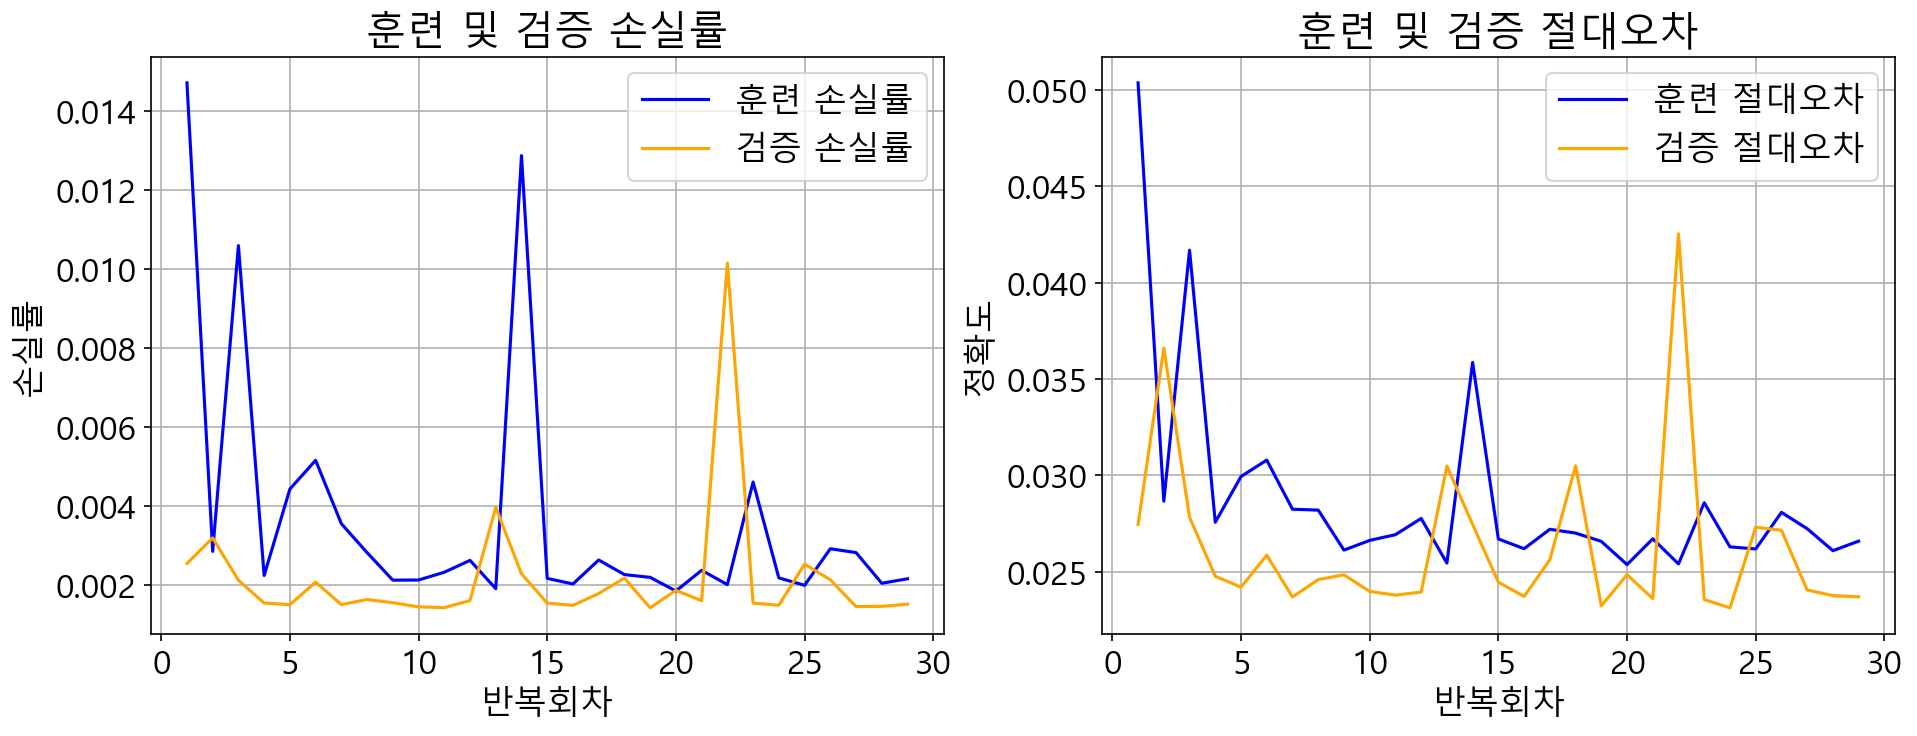

In [17]:
# 그래프 기본 설정
# ----------------------------------------
plt.rcParams["font.family"] = 'Malgun Gothic'
plt.rcParams["font.size"] = 16
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
# ----------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='loss', data=result_df, color='blue', label='훈련 손실률', ax=ax1)
sb.lineplot(x=result_df.index, y='val_loss', data=result_df, color='orange', label='검증 손실률', ax=ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
# ----------------------------------------
sb.lineplot(x=result_df.index, y='mae', data=result_df, color = 'blue', label = '훈련 절대오차', ax=ax2)
sb.lineplot(x=result_df.index, y='val_mae', data=result_df, color = 'orange', label = '검증 절대오차', ax=ax2)
ax2.set_title('훈련 및 검증 절대오차')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [18]:
evaluate1 = model.evaluate(x_train, y_train)
print("최종 훈련 손실률: %f, 최종 훈련 절대오차: %f" % (evaluate1[0], evaluate1[1]))

evaluate2 = model.evaluate(x_test, y_test)
print("최종 검증 손실률: %f, 최종 검증 절대오차: %f" % (evaluate2[0], evaluate2[1]))

  1/316 [..............................] - ETA: 5s - loss: 0.0013 - mae: 0.0233

316/316 [==============================] - 0s 903us/step - loss: 0.0018 - mae: 0.0249
최종 훈련 손실률: 0.001837, 최종 훈련 절대오차: 0.024946
136/136 [==============================] - 0s 906us/step - loss: 0.0015 - mae: 0.0237
최종 검증 손실률: 0.001521, 최종 검증 절대오차: 0.023691


## #08. 학습 결과 적용

### 예측 결과 산정

In [19]:
train_pred = model.predict(x_train)
test_pred = model.predict(x_test)

136/136 [==============================] - 0s 766us/step


### 결과 데이터 셋 구성

x_scale_df = DataFrame(x_scale, columns=['주행 실적 수', '주행 거리', '온실가스'])
y_scale_df = DataFrame(y_scale, columns=['마일리지'])

In [20]:
train_df = DataFrame(x_train, columns=['주행 실적 수', '주행 거리', '온실가스'])
train_df['마일리지(관측치)'] = y_train.flatten()
train_df['마일리지(예측치)'] = train_pred.flatten()

train_df['훈련오차'] = train_df['마일리지(관측치)']-train_df['마일리지(예측치)']

train_df.head()

,주행 실적 수,주행 거리,온실가스,마일리지(관측치),마일리지(예측치),훈련오차
0,-0.312006,-0.375659,-0.372719,-0.301166,-0.314641,0.013474
1,-0.420652,-0.422692,-0.417028,-0.408822,-0.412718,0.003896
2,-0.366329,-0.348368,-0.344372,-0.346023,-0.353787,0.007764
3,-0.312006,-0.072458,-0.049051,-0.283224,-0.291109,0.007885
4,-0.420652,-0.463647,-0.459255,-0.444707,-0.425906,-0.018801


In [21]:
test_df = DataFrame(x_test, columns=['주행 실적 수', '주행 거리', '온실가스'])
test_df['마일리지(관측치)'] = y_test.flatten()
test_df['마일리지(예측치)'] = test_pred.flatten()

test_df['훈련오차'] = test_df['마일리지(관측치)']-test_df['마일리지(예측치)']

test_df.head()

,주행 실적 수,주행 거리,온실가스,마일리지(관측치),마일리지(예측치),훈련오차
0,-0.420652,-0.444593,-0.437848,-0.408822,-0.417361,0.008539
1,-0.420652,-0.338055,-0.329798,-0.408822,-0.409237,0.000415
2,0.720129,0.689787,0.703826,0.813357,0.722022,0.091335
3,-0.366329,-0.314520,-0.316346,-0.346023,-0.349866,0.003843
4,-0.257683,-0.215974,-0.212940,-0.238367,-0.238371,0.000004


### 실제 결과값과 머신러닝에 의한 예측값 비교

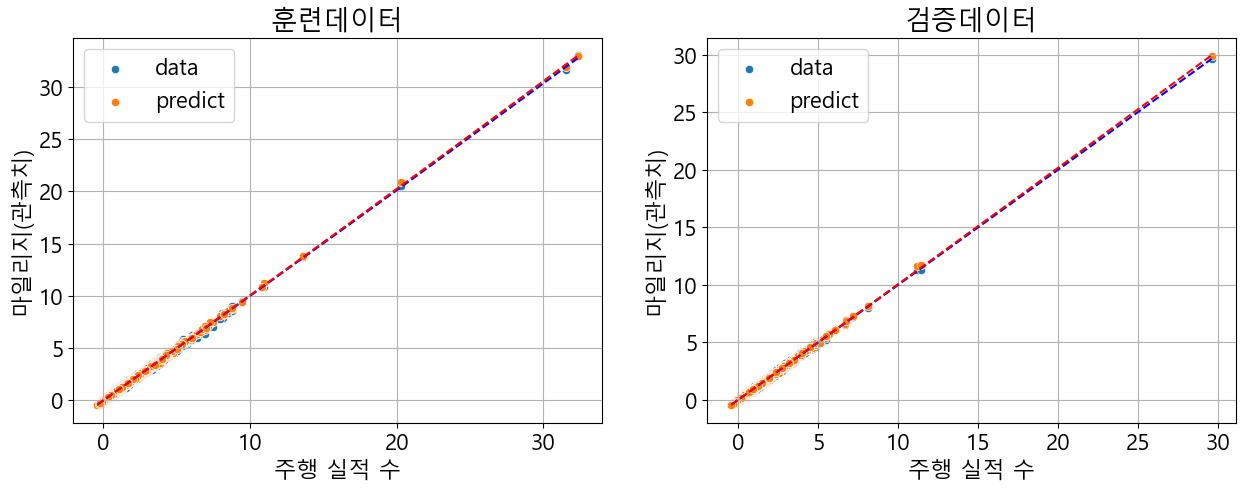

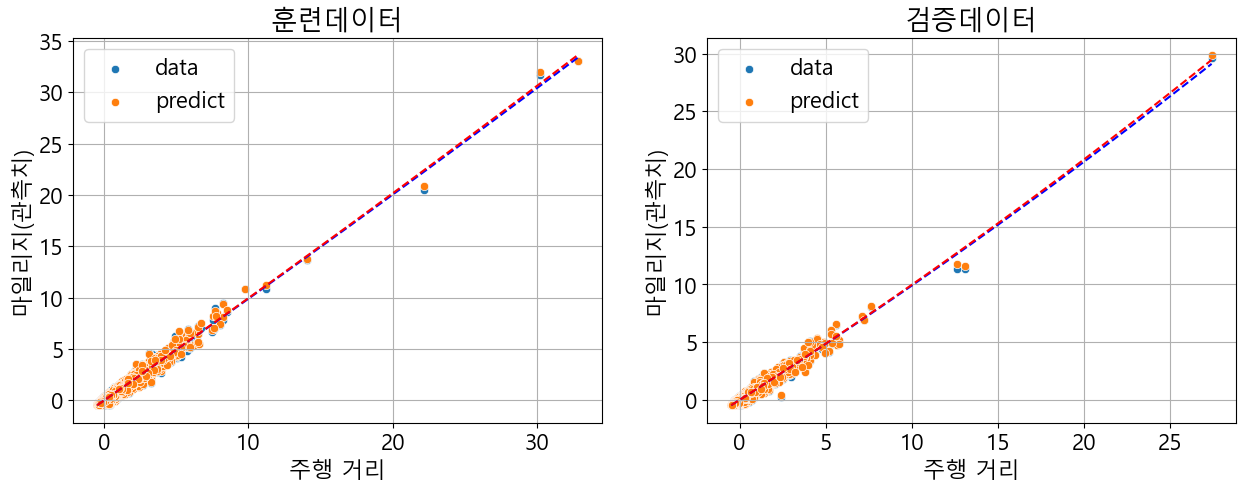

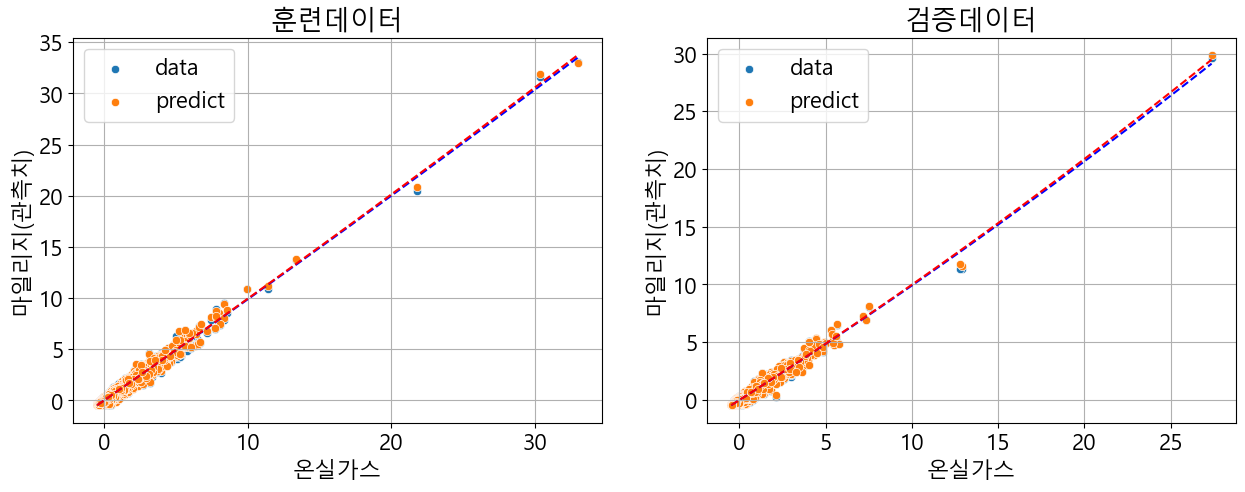

In [22]:
for key in ['주행 실적 수', '주행 거리', '온실가스']:
    helper.regplot(train_df[key], train_df['마일리지(관측치)'], train_df['마일리지(예측치)'], "훈련데이터",
                   test_df[key], test_df['마일리지(관측치)'], test_df['마일리지(예측치)'], "검증데이터",
                   figsize=(15, 5))